## Breakout - (Dueling DQN)
#### Dominick Stephens -- 22343288 | Amy Roys -- 22355561
#### Runs to end without error
- https://take-tech-engineer.com/gymnasium-atari-breakout/
- https://take-tech-engineer.com/dqn-atari-breakout-pytorch/
- https://www.daiphys.com/portal/ml/rl/breakout.html

## 1. Preparation

### 1.1. Install

In [1]:
## Python
!python --version

Python 3.10.12


In [2]:
## PyTorch
!python -c 'import torch; print(torch.__version__)'

2.2.1+cu121


In [3]:
## CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [4]:
!nvidia-smi

Tue Mar 19 13:36:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!apt-get update

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [770 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,012 kB]
Get:13 http://archive.ub

In [6]:
#!pip install --upgrade gymnasium[classic-control]
# Install Gym Environment
!pip install --upgrade gymnasium[atari]
!pip install --upgrade gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=89d038a093b618d803c23415a488e59e19689e9e050e60ab33df28362e59e49b
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [7]:
## Gymnasium 0.20.0+
# Gym Version
!python -c 'import gymnasium; print(gymnasium.__version__)'

0.29.1


### 1.2. Import

In [10]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import re
import csv
import math
import random
import time
import datetime

In [12]:
# Install Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
# Install Gym
import gymnasium as gym

In [14]:
# Install Data Tools
from collections import namedtuple
from collections import deque
from itertools import count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
import glob
import io
import base64
import IPython

In [16]:
import pygame
import moviepy

In [17]:
from typing import Optional

In [19]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = [12, 8]

In [20]:
plt.ion()

### 1.3. Setup

In [21]:
project = 'breakout'

In [22]:
# Set Directory for output videos and checkpoints of model

output_dir = project + '/output'
checkpoint_dir = project + '/checkpoint'

In [23]:
!mkdir -p $output_dir
!mkdir -p $checkpoint_dir

In [24]:
# Use CUDA if available otherwise use CPU, CUDA speeds up the training process
if torch.cuda.is_available() :
    device = 'cuda'
    #device = 'cuda:0'
else :
    device = 'cpu'

## 2. Sample (Breakout)

### 2.1. Environment

#### 2.1.1. Environment Setup

In [25]:
# Create a breakout environment
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

In [26]:
env = gym.wrappers.RecordVideo(env, output_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/breakout/output folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [27]:
## Action Space
env.action_space

Discrete(4)

In [28]:
## Observation Space
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [29]:
## Reward Range
env.reward_range

(-inf, inf)

In [30]:
# Reset environment and initialize state
state, info = env.reset(seed=random.randint(0, (2**24)))
state.size, info

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


(100800,
 {'lives': 5,
  'episode_frame_number': 0,
  'frame_number': 0,
  'seeds': (3888182262, 804244261)})

In [31]:
# Render of GYM environment
img = env.render()

In [32]:
state_text_01 = f'steps = 0'
state_text_02 = f'lives = {info["lives"]}'

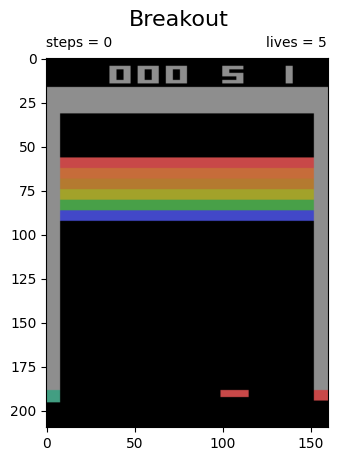

In [33]:
# Display the initial state

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Breakout', fontsize=16)
plt.imshow(img)
plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
plt.text(0.78, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
plt.show()

### 2.2. Algorithm

#### 2.2.1. Experience Replay Memory

In [34]:
# A namedtuple representing a single transition in the environment
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [35]:
# A class representing our memory buffer from which we will sample transitions to train the model.
class ReplayMemory(object) :
    def __init__(self, capacity) :
        self.memory = deque([], maxlen=capacity)
    def push(self, *args) :
        self.memory.append(Transition(*args))
    def sample(self, batch_size) :
        return random.sample(self.memory, batch_size)
    def __len__(self) :
        return len(self.memory)

#### 2.2.2. Network

##### 2.2.2.1. DQN - Multilayer Perceptron (MLP)

In [36]:
# A DQN MLP network

class DQN_MLP(nn.Module) :
    def __init__(self, n_observations, n_actions) :
        super(DQN_MLP, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x) :
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

##### 2.2.2.2. Dueling DQN - CNN

In [37]:
# Initialise the weights of the network

def weight_init(layers) :
    for layer in layers :
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [38]:
# See report for explanation of the network architecture
# DQN with a CNN architecture for image processing

class DuelingDQN_CNN(nn.Module) :
    def __init__(self, n_frames, n_actions) :
        super(DuelingDQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_frames, 32, 8, 4)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.flatten = nn.Flatten()
        self.fc_value1 = nn.Linear(3136, 512)
        self.fc_value2 = nn.Linear(512, 1)
        self.fc_advantage1 = nn.Linear(3136, 512)
        self.fc_advantage2 = nn.Linear(512, n_actions)
        weight_init([self.conv1, self.conv2, self.conv3, self.fc_value1, self.fc_value2, self.fc_advantage1, self.fc_advantage2])
    def forward(self, x) :
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x_value = F.relu(self.fc_value1(x))
        x_value = self.fc_value2(x_value)
        x_advantage = F.relu(self.fc_advantage1(x))
        x_advantage = self.fc_advantage2(x_advantage)
        q = x_value + x_advantage - x_advantage.mean()
        return q

#### 2.2.3. Action Selection (Epsilon-Greedy Algorithm)

In [39]:
# Decide on the action to take based on epsilon value

def select_action(state) :
    global steps_done
    sample = random.random()
    # Calculate epsilon threshold for epsilon-greedy action selection, varies on steps taken
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # If the sample is greater than the epsilon threshold, select the action with the highest Q-value
    if sample > eps_threshold :
        with torch.no_grad() :
            return policy_net(state).max(1)[1].view(1, 1), eps_threshold
    # Otherwise, select a random action
    else :
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold

#### 2.2.4. Training Loop

In [40]:
# Optimise and update the model

def optimize_model() :
    global state_action_values
    global loss
    # Check if the memory buffer has enough transitions to sample a batch
    if len(memory) < BATCH_SIZE :
        return
    # Sample a random batch of transitions from the memory buffer
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    # Create a mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    # Concatenate the batch of states, actions, and rewards
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # Calculate the Q-values of the non-final states
    with torch.no_grad() :
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Calculate the loss between the predicted Q-values and the expected Q-values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # optimize the model and update the weights
    optimizer.zero_grad()
    # Perform a backward pass
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()

#### 2.2.5. Plot Function

In [41]:
# Plot the rewards and steps

def plot_rewards(realtime=False) :
    fig = plt.figure()
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    steps = torch.tensor(episode_steps, dtype=torch.int)
    if realtime :
        plt.clf()
        plt.suptitle('Training...')
    else :
        plt.suptitle('Training Result')
    ax1 = fig.add_subplot(2, 1, 1)
    #ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(linestyle='--')
    ax1.tick_params('x', length=0)
    ax1.plot(rewards.numpy())
    if len(rewards) >= 100 :
        bin = 100
    else :
        bin = len(rewards)
    # Calculate the moving average of the rewards
    means = rewards.unfold(0, bin, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(bin - 1) + means[0], means))
    ax1.plot(means.numpy())
    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.grid(linestyle='--')
    ax2.plot(steps.numpy())
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0.10)
    plt.pause(0.001)
    if realtime :
        IPython.display.display(plt.gcf())
        IPython.display.clear_output(wait=True)
    else :
        IPython.display.display(plt.gcf())

#### 2.2.6. Utilities

In [42]:
# Converts the image to grayscale and resizes it to reduce memory usage

def image_preproc(img, size) :
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = cv2.resize(src=img, dsize=size)
    img = torch.tensor(img, dtype=torch.float32, device=device).unsqueeze(0)
    return img

In [43]:
# Converts text to integer if it is a digit

def atoi(text) :
    return int(text) if text.isdigit() else text

In [44]:
# Function to provide natural sorting order for strings containing numbers.

def natural_keys(text) :
    return [atoi(c) for c in re.split(r'(\d+)', text)]

### 2.3. Training

#### 2.3.1. Hyperparameters

In [1]:
## Q-Learning: Batch Size
BATCH_SIZE = 64
## Q-Learning: Discount Factor
GAMMA = 0.99
## Epsilon-Greedy Thresholds
EPS_START = 0.90
EPS_END = 0.05
EPS_DECAY = 1000
## Target Network: Update Rate
TAU = 0.005
## Optimizer: Learning Rate
LR = 1e-04
## Image Downsizing = (Width, Height)
IMAGE_SIZE = (84, 84)
## Number of Processing Frames
NUM_FRAMES = 6

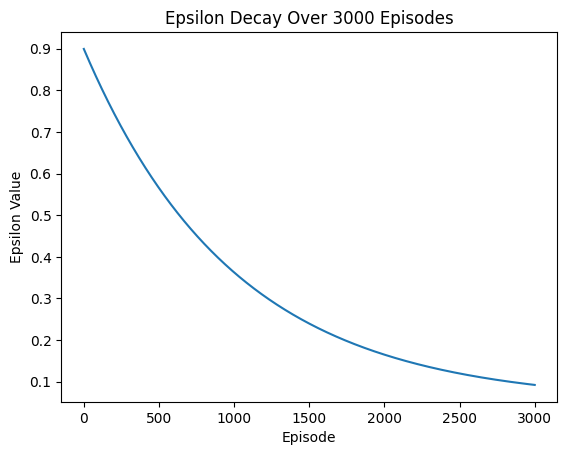

In [3]:
# Recalculate epsilon threshold for epsilon-greedy action selection for plotting

import math

steps_done = 0   # Counter for steps taken

def calculate_epsilon(steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    return eps_threshold

# Modeling over 3000 episodes
episodes = 3000
epsilon_values = []

for episode in range(1, episodes + 1):
    steps_done += 1
    epsilon = calculate_epsilon(steps_done)
    epsilon_values.append(epsilon)

# Visualizing epsilon values
import matplotlib.pyplot as plt

plt.plot(range(1, episodes + 1), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Over 3000 Episodes')
plt.show()


#### 2.3.2. Model Initialization

In [52]:
# Get Action space of the evironment

n_actions = env.action_space.n

In [53]:
# Initialize the policy and target networks

policy_net = DuelingDQN_CNN(NUM_FRAMES, n_actions).to(device)
target_net = DuelingDQN_CNN(NUM_FRAMES, n_actions).to(device)

In [54]:
# Loading the state dictionary of the policy network into the target network.
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [55]:
## In case of recovery - can load the model from the checkpoint
#policy_net.load_state_dict(torch.load(checkpoint_dir + '/policy_net_final.pth'))
#target_net.load_state_dict(torch.load(checkpoint_dir + '/target_net_final.pth'))

In [56]:
#Initialize the optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [57]:
# Initialize the memory buffer,
memory = ReplayMemory(10000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# Initialise Variables

steps_done = 0
state_action_values = np.array(0.0)
loss = 0.0
episode_rewards = []
episode_steps = []

#### 2.3.3. Training

In [60]:
# Roughly 1 hour per 1000 episodes on T4 GPU with Google Colab

num_episodes = 3000

In [61]:
# Save the model every 100 episodes in checkpoint dir

num_episodes_save = 100

episode: 2999, steps: 409, reward: 7.000, loss: 1.687e-03, mean_q: 2.647e+00


<Figure size 640x480 with 0 Axes>

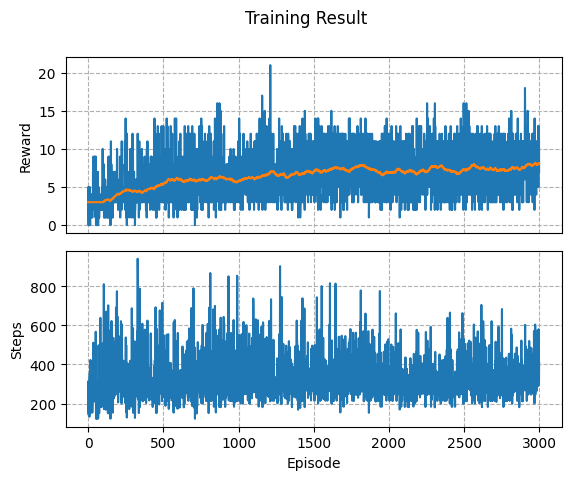

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [62]:
# Loop though the episodes

for i_episode in range(num_episodes) :

    # Initialize the environment and state
    state, info = env.reset(seed=random.randint(0, (2**24)))
    state = image_preproc(state, IMAGE_SIZE)
    frame = torch.zeros((1, NUM_FRAMES, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=torch.float32, device=device)
    frame[:, 0, :, :] = state
    next_frame = torch.zeros((1, NUM_FRAMES, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=torch.float32, device=device)
    next_frame[:, 0, :, :] = state

    # Initialize the reward for each episode
    reward_total = 0

    # Iterate over the episode steps
    for t in count() :
        # Select an action
        action, eps_threshold = select_action(frame)

        # Perform the action and observe the next state and reward
        observation, reward, terminated, truncated, info = env.step(action.item())
        observation = image_preproc(observation, IMAGE_SIZE)
        reward = torch.tensor([reward], device=device)
        reward_total += reward
        done = terminated or truncated

        # checks if the episode is terminated and sets the next frame to None
        if terminated :
            next_frame = None
        else :
            next_frame = torch.roll(input=next_frame, shifts=1, dims=1)
            next_frame[:, 0, :, :] = observation
        memory.push(frame, action, next_frame, reward)
        frame = next_frame

        # Call the optimization function
        optimize_model()

        # Update the target and policy network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # Update the target network using the policy network and the target network with a soft update (TAU)
        for key in policy_net_state_dict :
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        # If the episode is terminated, break the loop
        if done :
            episode_rewards.append(reward_total)
            episode_steps.append(t + 1)
            print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')

            # Plot the rewards and steps
            if i_episode % 20 == 0 :
                IPython.display.clear_output(wait=True)
                plot_rewards(realtime=False)
            break

    # Save the model every 100 episodes
    if (i_episode % num_episodes_save == 0) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_' + str(i_episode) + '.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_' + str(i_episode) + '.pth')

    # Save the final model
    if (i_episode == range(num_episodes)[-1]) :
        torch.save(policy_net.state_dict(), checkpoint_dir + '/policy_net_final.pth')
        torch.save(target_net.state_dict(), checkpoint_dir + '/target_net_final.pth')

IPython.display.clear_output(wait=True)
print(f'episode: {i_episode}, steps: {(t + 1)}, reward: {reward_total[0]:.3f}, loss: {loss:.3e}, mean_q: {state_action_values.mean():.3e}')
plot_rewards()

#### 2.3.4. Video Output

In [63]:
# Display the training video output

mp4list = glob.glob(output_dir + '/rl-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.4. Play

#### 2.4.1. Trained Model

In [99]:
# Load the Breakout environment
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

In [100]:
env = gym.wrappers.RecordVideo(env, output_dir, name_prefix='play-video')
#env = gym.wrappers.RecordVideo(env, output_dir, episode_trigger=(lambda ep: ep == 0 or ep == 9 or ep % 100 == 99), name_prefix='play-video')

In [101]:
n_actions = env.action_space.n

In [102]:
state, info = env.reset(seed=random.randint(0, (2**24)))

In [103]:
n_observations = state.size

In [104]:
# Initialize the policy network
policy_net = DuelingDQN_CNN(NUM_FRAMES, n_actions).to(device)

In [105]:
# Load the final model

pthlist = glob.glob(checkpoint_dir + '/policy_net_*.pth')
pthfile = sorted(pthlist, key=natural_keys)[-1]
pthfile

'breakout/checkpoint/policy_net_final.pth'

In [106]:
# Load the model into the policy network
policy_net.load_state_dict(torch.load(pthfile))

<All keys matched successfully>

In [107]:
policy_net.eval()

DuelingDQN_CNN(
  (conv1): Conv2d(6, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_value1): Linear(in_features=3136, out_features=512, bias=True)
  (fc_value2): Linear(in_features=512, out_features=1, bias=True)
  (fc_advantage1): Linear(in_features=3136, out_features=512, bias=True)
  (fc_advantage2): Linear(in_features=512, out_features=4, bias=True)
)

#### 2.4.2. Play

steps: 282{'lives': 0, 'episode_frame_number': 1131, 'frame_number': 1131}


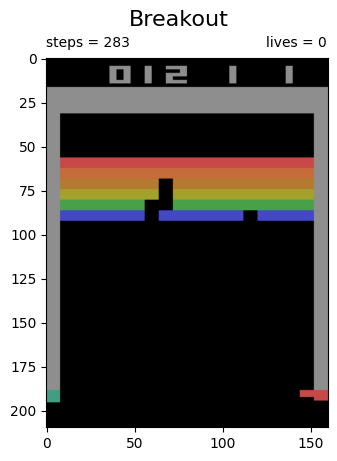

In [116]:
# Play the game using the trained model and display the video output

state, info = env.reset(seed=random.randint(0, (2**24)))
observation = state
state = image_preproc(state, IMAGE_SIZE)

frame = torch.zeros((1, NUM_FRAMES, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=torch.float32, device=device)
frame[:, 0, :, :] = state
next_frame = torch.zeros((1, NUM_FRAMES, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=torch.float32, device=device)
next_frame[:, 0, :, :] = state

steps = 0
ims = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.suptitle('Breakout', fontsize=16)

## Initial Frame
state_text_01 = f'steps = {steps}'
state_text_02 = f'lives = {info["lives"]}'
img = env.render()
image = plt.imshow(img, animated=True)
text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
text_02 = plt.text(0.78, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
ims.append([image] + [text_01] + [text_02])
plt.gca().texts[-1].set_visible(False)
plt.gca().texts[-2].set_visible(False)

while True :
    print('\r' + 'steps: ' + str(steps), end='')
    # print('\r' + 'reward: ' + str(reward), end='')
    action = policy_net(frame).max(1)[1].view(1, 1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    #Perform Preprocessing
    observation = image_preproc(observation, IMAGE_SIZE)
    # Plot the game state
    steps += 1
    state_text_01 = f'steps = {steps}'
    state_text_02 = f'lives = {info["lives"]}'
    img = env.render()
    image = plt.imshow(img, animated=True)
    text_01 = plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
    text_02 = plt.text(0.78, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
    ims.append([image] + [text_01] + [text_02])
    plt.gca().texts[-1].set_visible(False)
    plt.gca().texts[-2].set_visible(False)
    done = terminated or truncated
    if terminated :
        #next_state = None
        next_frame = None
    else :
        #next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        next_frame = torch.roll(input=next_frame, shifts=1, dims=1)
        next_frame[:, 0, :, :] = observation
    #state = next_state
    frame = next_frame
    if done :
        plt.gca().texts[-1].set_visible(True)
        plt.gca().texts[-2].set_visible(True)
        print(info)
        break

#### 2.4.3. Video Output

In [117]:
# Display the play video output

mp4list = glob.glob(output_dir + '/play-video-episode-*.mp4')
if len(mp4list) > 0 :
    for mp4 in sorted(mp4list, key=natural_keys)[::(len(mp4list) - 1 if len(mp4list) >= 2 else 1)] :
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        IPython.display.display(IPython.display.HTML(data='''{mp4}<br>
            <video alt="{mp4}" autoplay loop controls style="height: 200px;">
            <source src="data:video/mp4;base64,{src}" type="video/mp4">
            </video>'''.format(mp4=mp4, src=encoded.decode('ascii'))))

In [75]:
# If in Google Colab, download the file output as a zip file

# !zip -r /content/file.zip /content/breakout
#
# from google.colab import files
# files.download("/content/file.zip")

  adding: content/breakout/ (stored 0%)
  adding: content/breakout/output/ (stored 0%)
  adding: content/breakout/output/rl-video-episode-729.meta.json (deflated 7%)
  adding: content/breakout/output/rl-video-episode-343.mp4 (deflated 47%)
  adding: content/breakout/output/rl-video-episode-0.meta.json (deflated 13%)
  adding: content/breakout/output/play-video-episode-0.meta.json (deflated 13%)
  adding: content/breakout/output/rl-video-episode-3000.meta.json (deflated 7%)
  adding: content/breakout/output/rl-video-episode-216.meta.json (deflated 8%)
  adding: content/breakout/output/play-video-episode-0.mp4 (deflated 25%)
  adding: content/breakout/output/rl-video-episode-8.meta.json (deflated 10%)
  adding: content/breakout/output/rl-video-episode-2000.mp4 (deflated 26%)
  adding: content/breakout/output/rl-video-episode-8.mp4 (deflated 24%)
  adding: content/breakout/output/rl-video-episode-1.mp4 (deflated 28%)
  adding: content/breakout/output/rl-video-episode-64.mp4 (deflated 25%)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.4.4. GIF Output

In [76]:
# Save the play video output as a GIF

gif = output_dir + '/play-video-episode-0.gif'

In [118]:
fig.set_size_inches(6.4, 4.8, forward=True)

In [119]:
ani = matplotlib.animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save(gif, writer="pillow")

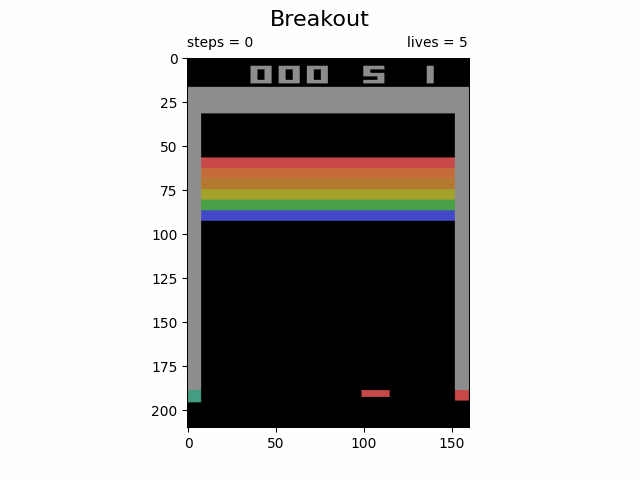

In [120]:
IPython.display.Image(gif, format='gif')